This is note the main notebook in this challenge. See `redo-chat-eval-and-repeat-sft-train.ipynb`.

### Investigate eval and sft train runs on GPU

Investigate the runs in `redo-chat-eval-and-repeat-sft-train.ipynb`

1) Why did repeating the same training with the same defaults result in different final validation loss and different chat eval accuracy? (This is shown in the last few runs.)
   
2) Did I learn anything from evaluating validation loss more frequently?

3) Compare chat eval before and after adding tool (python) calling to the engine.

Big question: is this training working properly and is it doing anything? I'd like to try to answer without comparing against reports from the "official" training or re-training using the official code and comparing against that.

### #3

Let me start with 3 because I think it's straighforward.

In `challenge-30-sft-train-d20/sft-train-d20.ipynb` I ran chat_eval before I "fixed" the engine in challenge 31. In this challenge, I ran chat_eval again. This was on identical mid and sft models.

Here are the accuracies copied from `challenge-30-sft-train-d20/sft-train-d20.ipynb` (before engine fix):

```
                   mid        sft       

ARC-Easy           43.18      44.07
ARC-Challenge      33.19      31.74
MMLU               33.07      32.34
GSM8K              2.20       3.71
HumanEval          6.71       6.10
SpellingBee        97.27      95.70
```

And here are the accuracies from the two runs of chat_eval at the top of `redo-chat-eval-and-repeat-sft-train.ipynb`:

```
                   mid        sft         increase (from mid to sft)

ARC-Easy           43.18      44.07       2.1%
ARC-Challenge      33.19      31.74       -4.4%
MMLU               33.07      32.34       -2.2% 
GSM8K              3.41       5.38        57.8%
HumanEval          6.71       6.10        -9%
SpellingBee        98.05      96.88       -1.2%
```

ARC-Easy, ARC-Challenge, MMLU, and HumanEval are the same. GSM8K and SpellingBee are different, and in both cases greater with the fixed engine. All of this makes sense because only GSM8K and SpellingBee should cause the assistant to use the python calculator.

But now looking mid to sft with the fixed engine, some tasks go up and others go down. Are the changes in accuracy big enough to be something beyond noise? In other words, if I retrained mid a few times with a different shuffling of data, and retrained sft a few times with differnet shuffling of data, would I still expect to see differeces in accuracy of about the same amount and direction?

I'm going to assume yes, at least for now, because the "unexplained" changes in accuracy of ARC-Easy from repeated trainings of SFT were much smaller than the 1.2% to 57.8% chages we see above. (I can poke some holes in that argument but will leave it for now.)

And as discussed in `challenge-30-sft-train-d20/look-into-observations.ipynb`:

```
                            % of training data measured by rows
                                    mid              sft
                   
ARC-Easy                            0%               10%
ARC-Challenge                       0%               4.8%
MMLU                                12%              0%
GSM8K                               0.9%             35%
HumanEval                           0%               0%
SpellingBee                         9%               1.3%        
SpellingBee + SimpleSpelling        33%              2.6^
```

We see accuracy go up for ARC-Easy and GSM8K both of which are much more represnted in SFT training data. So it does feel like yes, this training is doing "something." 

But is it working as expected? Are we ending up in a better place? Did we achieve soemthing useful by trying to nudge the model to not generate user tokens or python output tokens? I don't know.

(BTW, should really be looking at centered accuracies. Another sign that I should get the reporting stuff in place before spending too much time on this stuff.)

### #2

Did I learn anything from evaluating validation loss more frequently? With more steps?

I tried:

```
run     eval_every     eval_steps   TEPS  |  starting_validation_loss  final_validation_loss

32-1:   25             100 *        32 *     1.011101                  1.013690
32-2:   10             200          32 *     1.019773                  1.022344
32-3:   25             100 *        64       1.011101                  1.013553
32-4:   100 *          100 *        32 *     1.011101                  1.013646
32-5    100 *          100 *        32 *     1.011101                  1.013710

TEPS = target_examples_per_step
* = default, not set by command line argument
```

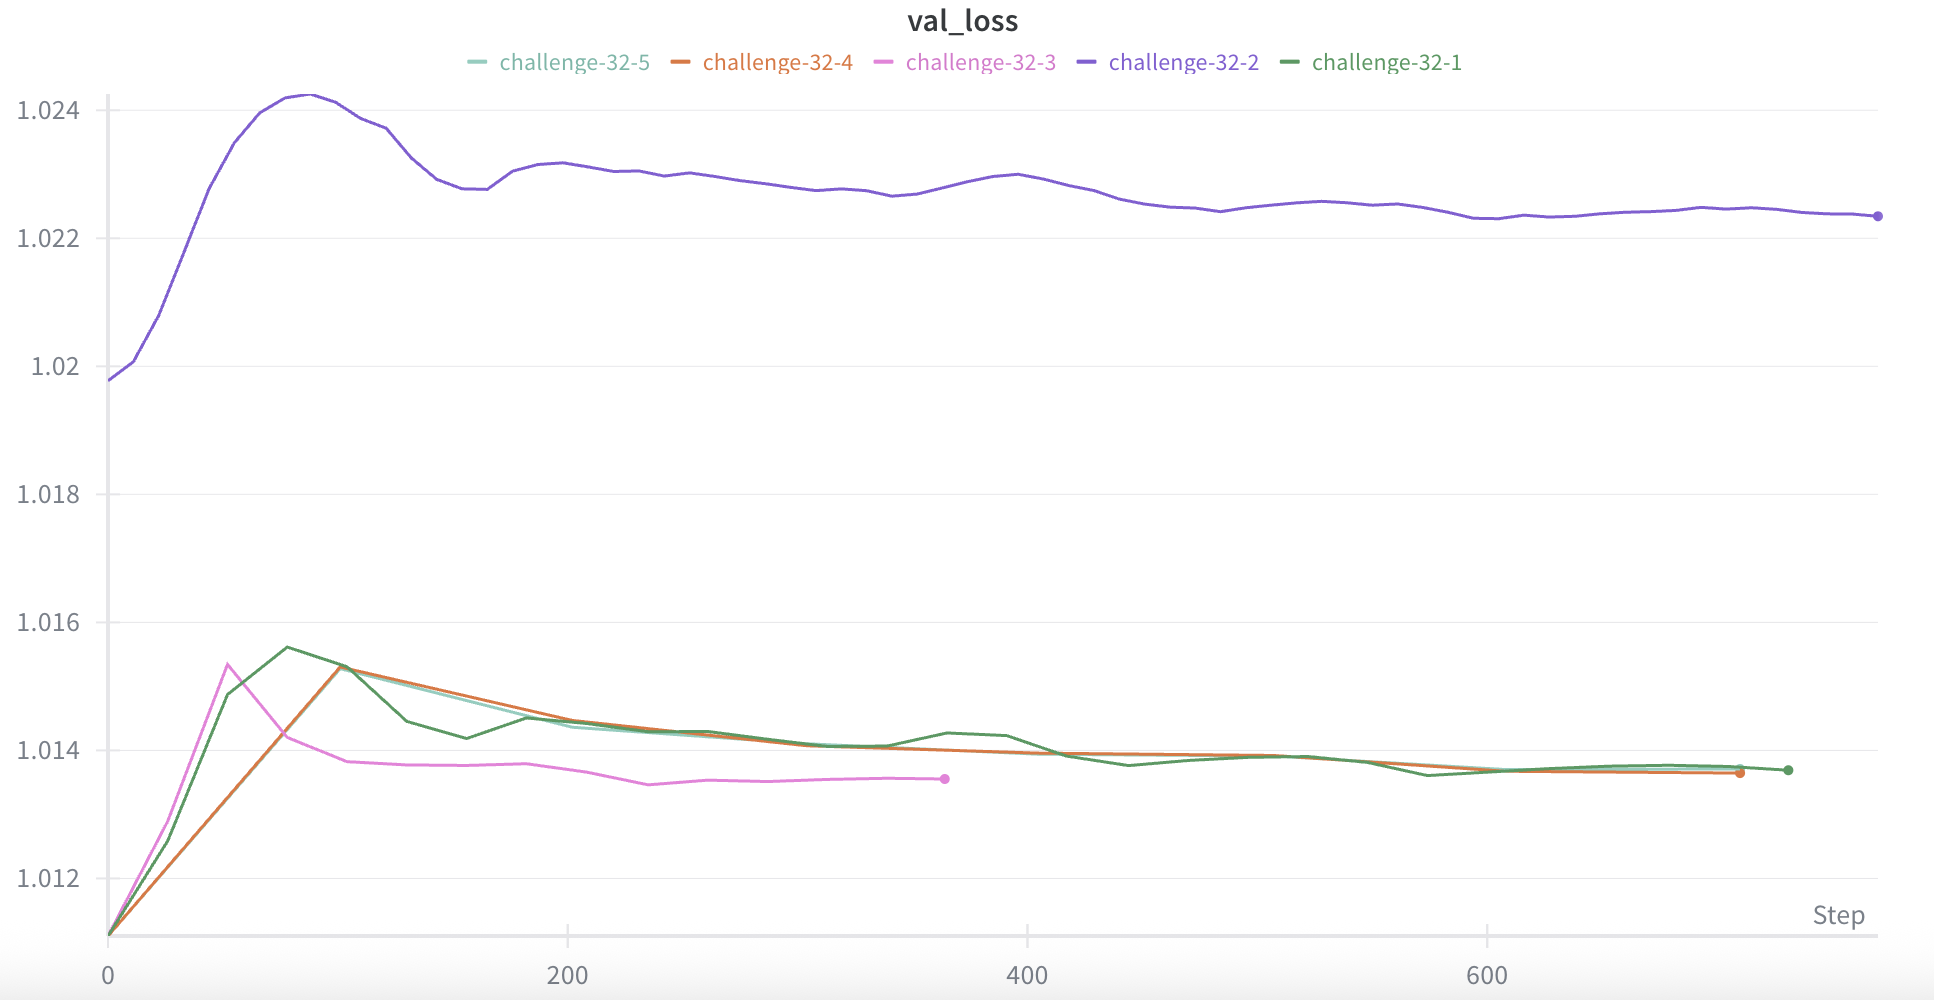

The first thing that jumps out is that run 32-2, the one where 200 steps were used to evaluate loss, is completely separated from the other runs. 100 is a lot of steps (1/7th of whole training) and 200 is double that.

If this training is working as expected, then this separation just means that choosing one set of data or a larger superset for validation happens to have more influence over the validation loss than the improvements we make over training for an epoch. Perhaps it's a reminder to be very careful about when you can and can't compare validation loss from one situation to another and that validation loss. Maybe validation is more useful within a run to make sure training is behaving and you're not overfiting.

On the the other hand, I could have copied something wrong, left something out, or did something else wrong along the way and this training isn't working as expected. It's possible in a proper run the validation loss would decrese more dramatically and when looking at the plot the initial difference (1.011 to 1.019) would barely be visible and there would be almost no or no separation between 32-2 and the others over the steps.

Now back to what motivated this in the first place--why the initial increase in validation loss? This doesn't add too much to the discussion in `challenge-30-sft-train-d20/look-into-observations.ipynb` other than to see the peak happens at around 80 steps and to see that the rise happens over those 80 steps vs something really odd like a sudden jump after the first training step. This could all be normal. Or the fact that we never get below our starting poitn is bad. Just not sure.

### #1

Why did repeating the same training with the same defaults result in different final validation loss and different chat eval accuracy? (This is shown in the last few runs.)

SFT train runs 32-4 and 32-5 should be identical. However:

```
                                                 32-4          32-5           % change

Starting validation loss                         1.011101      1.011101       0
Training loss on step 5                          0.847359      0.847999       0.076%
Num tokens on step 5                             8,344         8,344          0
Final validation loss                            1.013646      1.013710       0.006%      
ARC-Easy subset measured in training loop        0.449219      0.450195       0.21% (460 -> 461 right)
MMLU subset measure in training loop             0.348633      0.351562       0.84% (357 -> 360 right)
ARC-Easy accuracy from chat_eval                 44.57%        44.36%         -0.47% (1059 -> 1054 right)

```

Hmm, that difference in training loss is a clue. Look at that from step 0:

```
           32-4                             32-5
           training loss  num tokens        training loss  num tokens       % change

Step 0     0.767198       9,718             0.767198       9,718            0
Step 1     0.765703       13,979            0.765595       13,979           -0.014%
Step 2     1.094785       11,283            1.094171       11,283           -0.056%
Step 3     1.216676       12,682            1.217205       12,682           0.043%
Step 4     0.786972       9,509             0.786474       9,509            -0.063%
Step 5     0.847359       8,344             0.847999       8,344            0.076%
```

Num tokens lines up so I'm pretty confident there is nothing different about the data betwee runs.

Training loss for step 0 is training loss on rank 0 from the first batch of inputs.

Training loss for step 1 is after gradients were computed in step 0, averaged across ranks, and weights adjusted.

Considering the precision we're working with and the number of parameters maybe the differences in loss between the runs are totally valid in the sense they're both reasonably close to the true value if we had infinite precision, but I don't get why all the operations are not entirely deterministic.

Could it have something to do with multiple GPUs? I would imagine torch.dist always assigns rank 0 to GPU 0, rank 1 to GPU 1, etc. and whatever operations are done to move tensors around during averaging the gradient and sending out the updated weights also stick to a certain order.

I can think of so many things to try: from identical run to identical run on my mac do I see differences in the loss at each step? What about on a single GPU? If so, can I find the first place it diverges? Like in the gradient? Or in the updated weights?

But with this one let me try looking it up first. Start with ChatGPT. "If I do multiple identical training runs of a deep learning model on a GPU with fixed random seeds, should I expect to see identical loss after step 1, step 2, etc. across the runs?"

=== ChatGPT: ===

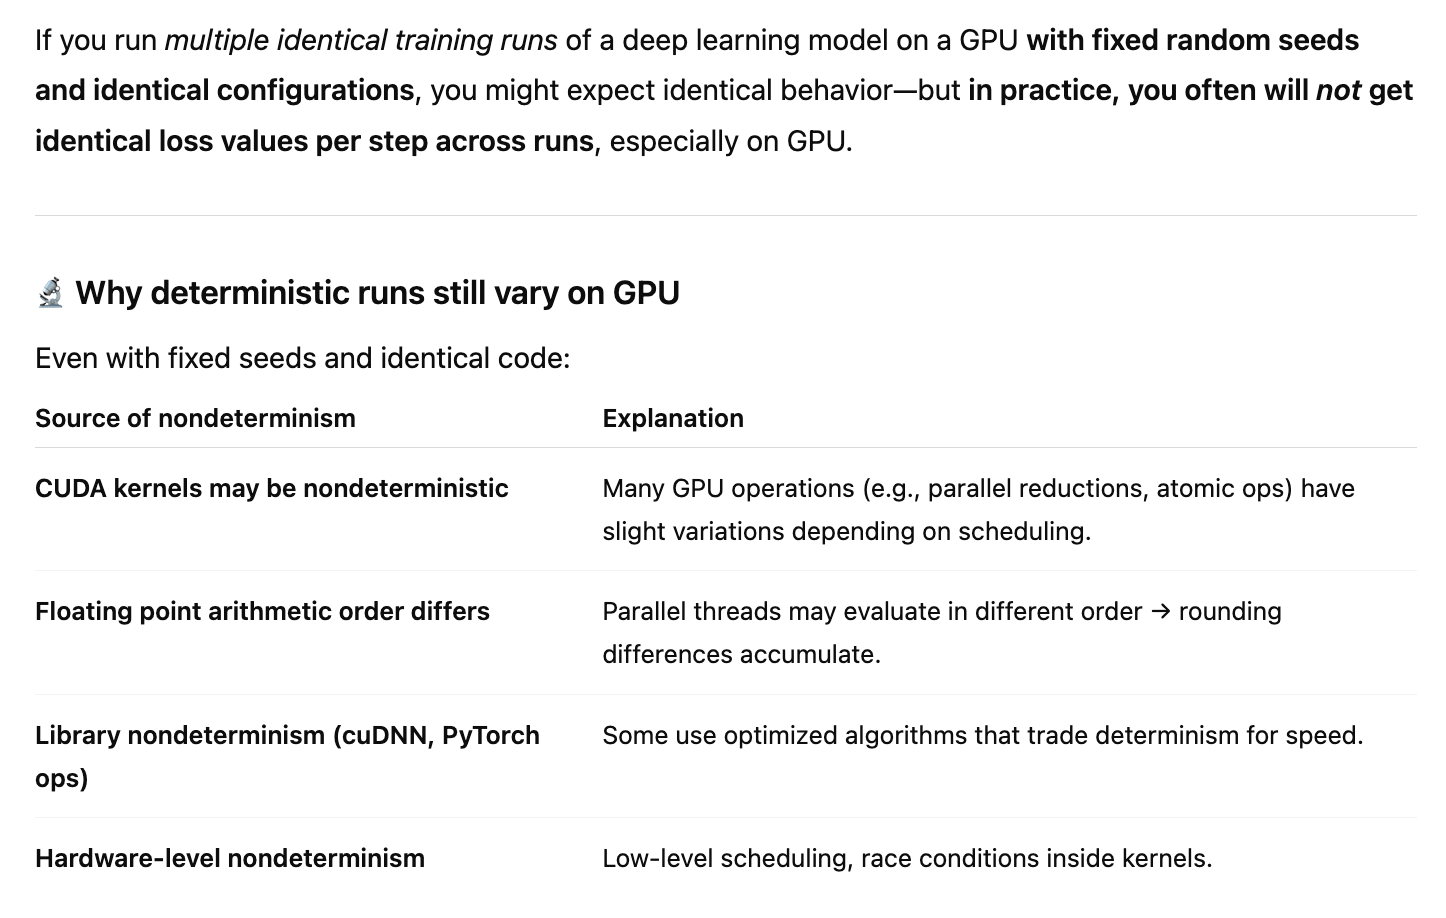

📌 What happens in practice?

Step-by-step loss values will typically diverge slightly starting from the very first forward/backward pass.

The divergence is often small at first (e.g., 1e-6 to 1e-4), then grows due to chaotic dynamics.

After hundreds or thousands of steps, runs can diverge significantly.

✔ So no: identical loss per step should not be expected.

🧠 Final thought

Model training is chaotic — even microscopic numerical differences lead to divergence. What matters is statistical consistency, not identical trajectories.

=== end ChatGPT ===

Is that all true? I asked for sources and one thing it pointed to is this: https://docs.pytorch.org/docs/stable/notes/randomness.html

Anyway, maybe it doesn't matter. Unless I really screwed something up, it seems clear and not surprising that changing the the order of the training data (e.g. by choosing a different random seed) will cause changes in the model that are easily visible in the validation loss and accuracy numbers, and I assume these changes will be the same or bigger than changes caused by indeterminism. (Maybe should check this.) (Also, not in this sft training, but in other training could also have random init of weights and random dropout.) I have the luxury of following an architecture and using hyperparmaters that someone else already figured out. But if I want to try something new, I need to know how to measure a true, meaningful change in say loss or accuracy. The trick to distinguishing signal from noise say when tuning a hyperparameter is probably to train multiple times with different orders or subsets of training data, etc. There must be all sorts of formal techniques around this, appropriate statistics to use, and tools to help.

All that and I stil don't know if this training worked as expected. I know it did "something." Accuracy on some tasks went up, it went down on others, and validation loss measured using either 3,200 or 6,400 SmolTalk conversations got worse.

I think I should move on for now (to creating the chat CLI and maybe the chat web UI). Then I should go back and see what the reporting stuff is about and potentially add it, especially if it will help stay more organized about collecting and viewing metrics. I can then see what information is available from the official runs and/or do my own runs using the official code and compare. I'll want to be more confident that SFT train (and also mid train and base train) of d20 were on track before training d32.